# Using Sequence Networks (LSTMs) for synthetic Time Series 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Generating Synthetic Data

In [2]:
def plot_series(time, series, format='-', start=00, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Series")
  plt.grid(True)

def trend(time, slope=0):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd= np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level


In [3]:

time = np.arange(4*365+1, dtype='float32')
baseline = 10
series = trend(time, slope=0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [4]:
series = baseline + trend(time, slope)+ seasonality(time, 365, amplitude)
# updating it with Noise
series+=series+noise(time, noise_level, 42)

### Splitting the data in Training and Testing Set

In [5]:
split_time = 1000
train_time = time[:split_time]
x_train = series[:split_time]
valid_time = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 20
batch_size = 32
shuffle_batch_size = 1000

### Preparing a Tensorflow Dataset

In [7]:
def window_dataset(series, window_size, batch_size ,shuffle_batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_batch_size).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Creating the LSTMs model

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_batch_size)

model =tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                   tf.keras.layers.Dense(1),
                                   tf.keras.layers.Lambda(lambda x: x*100.0)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20)
)
model.compile(loss = tf.keras.losses.Huber(), optimizer= tf.keras.optimizers.SGD(lr = 1e-8,momentum = 0.9))
history = model.fit(train_set, epochs = 100, callbacks = [lr_scheduler])


Epoch 1/100
31/31 [==============================] - 0s 10ms/step - loss: 62.4116
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 61.6053
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 60.6489
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 59.5708
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 58.3001
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 56.4637
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 53.0145
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 51.4005
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 50.0223
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 48.5895
Epoch 11/100
31/31 [==============================] - 0s 9ms/step - loss: 47.0711
Epoch 12/100
31/31 [==============================] - 0s 9ms/step - loss: 45.4591
Epoch 13/100
31/31 [==

(1e-08, 0.0001, 0.0, 30.0)

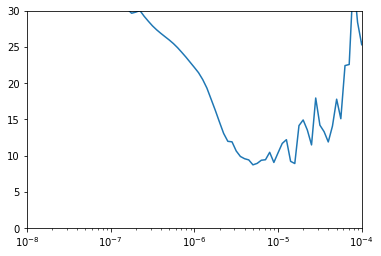

In [9]:
plt.semilogx( history.history['lr'],history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_batch_size)

model =tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                   tf.keras.layers.Dense(1),
                                   tf.keras.layers.Lambda(lambda x: x*100.0)
])

model.compile(loss = tf.keras.losses.Huber(), optimizer= tf.keras.optimizers.SGD(lr = 6e-6,momentum = 0.9), metrics = ['mae'])
history = model.fit(train_set, epochs = 500)

Epoch 1/500
31/31 [==============================] - 0s 10ms/step - loss: 35.7698 - mae: 36.2651
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 26.5877 - mae: 27.0826
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 21.8231 - mae: 22.3167
Epoch 4/500
31/31 [==============================] - 0s 10ms/step - loss: 16.9673 - mae: 17.4607
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 12.4650 - mae: 12.9524
Epoch 6/500
31/31 [==============================] - 0s 10ms/step - loss: 10.4453 - mae: 10.9303
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 9.8731 - mae: 10.3583
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 9.0236 - mae: 9.5090
Epoch 9/500
31/31 [==============================] - 0s 9ms/step - loss: 8.8462 - mae: 9.3355
Epoch 10/500
31/31 [==============================] - 0s 9ms/step - loss: 10.8296 - mae: 11.3191
Epoch 11/500
31/31 [==================

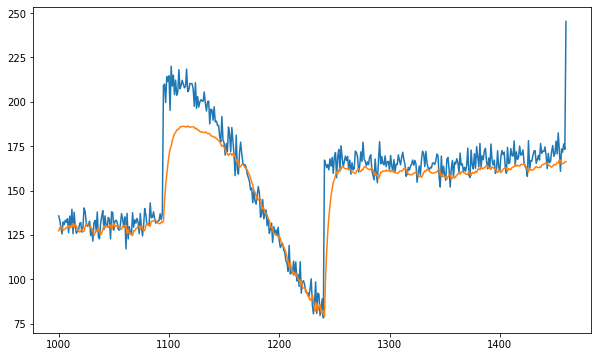

In [11]:
forecast = []

for time in range(len(series)- window_size):
  forecast.append(model.predict(series[time: time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0 ,0]

plt.figure(figsize = (10,6))
plt.plot(valid_time, x_valid)
plt.plot(valid_time, results)


In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.249941

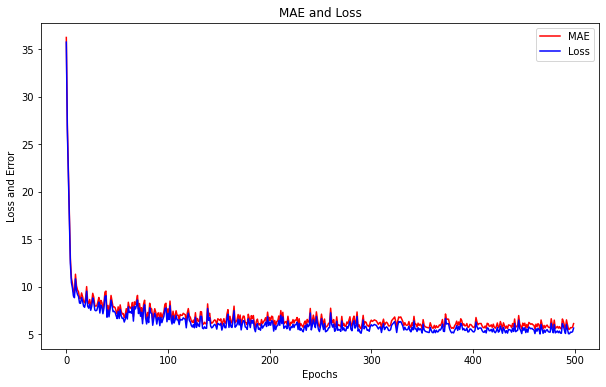

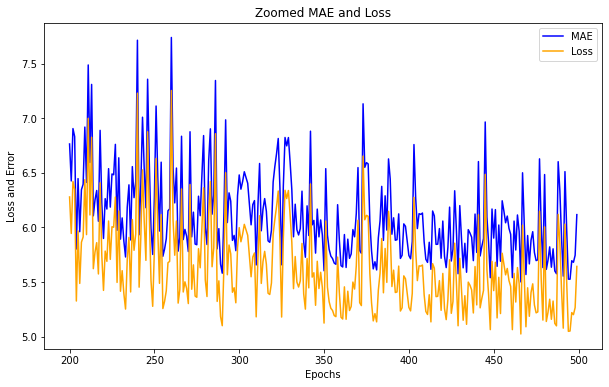

In [14]:
import matplotlib.image as mpimg
mae = history.history['mae']
loss = history.history['loss']
epochs = len(loss)
#----------------------------------------
# Visualizing the mae and loss
# ---------------------------------------
plt.figure(figsize = (10,6))

plt.plot(range(epochs), mae, 'r')
plt.plot(range(epochs), loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss and Error")
plt.legend(["MAE", "Loss"])

#----------------------------------------
# Visualizing the mae and loss
# ---------------------------------------
plt.figure(figsize = (10,6))


plt.plot(range(200,epochs), mae[200:],'b')
plt.plot(range(200,epochs), loss[200:],'orange')
plt.title('Zoomed MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss and Error")
plt.legend(["MAE", "Loss"])

In [21]:
tf.keras.backend.clear_session()
train_set = window_dataset(x_train, window_size, batch_size, shuffle_batch_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=['mae'])
history = model.fit(train_set,epochs=200)

Epoch 1/200
31/31 [==============================] - 0s 13ms/step - loss: 57.8504 - mae: 58.3485
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 32.3522 - mae: 32.8510
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 28.5425 - mae: 29.0400
Epoch 4/200
31/31 [==============================] - 0s 13ms/step - loss: 27.2954 - mae: 27.7897
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 26.3119 - mae: 26.8082
Epoch 6/200
31/31 [==============================] - 0s 14ms/step - loss: 24.9699 - mae: 25.4649
Epoch 7/200
31/31 [==============================] - 0s 13ms/step - loss: 23.8620 - mae: 24.3569
Epoch 8/200
31/31 [==============================] - 0s 14ms/step - loss: 23.1538 - mae: 23.6486
Epoch 9/200
31/31 [==============================] - 0s 13ms/step - loss: 22.4260 - mae: 22.9220
Epoch 10/200
31/31 [==============================] - 0s 13ms/step - loss: 21.6570 - mae: 22.1510
Epoch 11/200
31/31 [=========

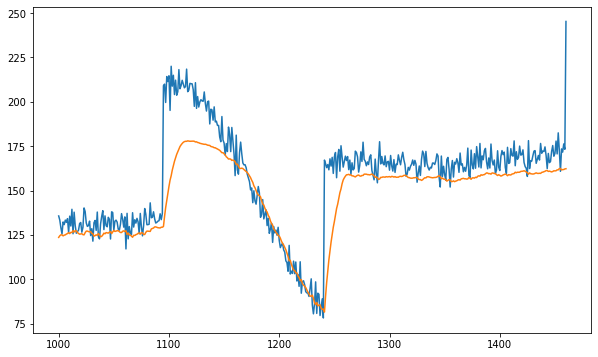

In [27]:
forecast = []

for time in range(len(series)- window_size):
  forecast.append(model.predict(series[time: time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0 ,0]

plt.figure(figsize = (10,6))
plt.plot(valid_time, x_valid)
plt.plot(valid_time, results)


In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

11.432669

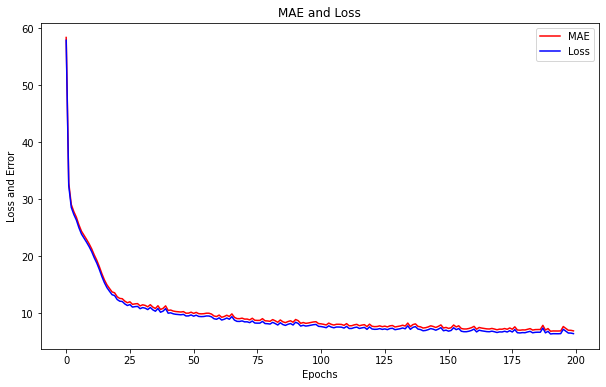

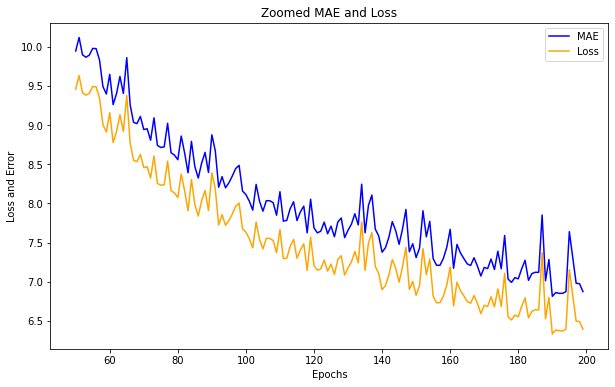

In [29]:
import matplotlib.image as mpimg
mae = history.history['mae']
loss = history.history['loss']
epochs = len(loss)
#----------------------------------------
# Visualizing the mae and loss
# ---------------------------------------
plt.figure(figsize = (10,6))

plt.plot(range(epochs), mae, 'r')
plt.plot(range(epochs), loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss and Error")
plt.legend(["MAE", "Loss"])

#----------------------------------------
# Visualizing the mae and loss
# ---------------------------------------
plt.figure(figsize = (10,6))


plt.plot(range(50,epochs), mae[50:],'b')
plt.plot(range(50,epochs), loss[50:],'orange')
plt.title('Zoomed MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss and Error")
plt.legend(["MAE", "Loss"])